In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [3]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep

In [6]:
experience = 1

number_columns = 5
#number_columns = 3
#number_columns = 2

def construct_training_labels(number_columns, labels):
  n = labels.shape[0]
  training_labels = np.zeros((n,number_columns))
  for i in range(n):
    training_labels[i][labels[i]] = 1
  return training_labels

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_wake(val):
  arr = {'N1':0, 'N2':0, 'N3':0, 'REM':0, 'Wake':1, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_pos(val):
  arr = {'Supine;':0, 'Upright;':1, 'Right;':2, 'Prone;':3, 'Left;':4, 'Artefact;':np.NaN, 'A;':np.NaN}
  return arr[val]

def encode_sleep_hr(val):
  if val == 'A;':
    return np.NaN
  n = len(val)
  val = int(val[:n-1])
  if (val < 60):
    return 0
  if (val < 100 and val >= 60):
    return 1
  return 2

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

file_name = os.path.join(features_dir, "Unlabelled")
#file_name = os.path.join(features_dir, "UnlabelledHR")
#file_name = os.path.join(features_dir, "UnlabelledPOS")

unlabelled_dataset = pd.read_pickle(file_name)

file_name_stage = os.path.join(features_dir, "Labelled")
file_name_hr = os.path.join(features_dir, "LabelledHR")
file_name_pos = os.path.join(features_dir, "LabelledPOS")

labelled_dataset_stage = pd.read_pickle(file_name_stage)
labelled_dataset_wake = pd.read_pickle(file_name_stage)
labelled_dataset_hr = pd.read_pickle(file_name_hr)
labelled_dataset_pos = pd.read_pickle(file_name_pos)

OnLabel = ["Label",'Sleep State']

for i in range(49):
  OnLabel.append(str(i))

new_labelled_dataset = pd.merge(labelled_dataset_stage, labelled_dataset_pos, on=OnLabel)
merged_test_dataset = pd.merge(new_labelled_dataset, labelled_dataset_hr, on=OnLabel)
merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep State']

#print(new_labelled_dataset)

labels_stage = merged_test_dataset['Sleep State']
labels_wake = merged_test_dataset['Sleep Wake']
labels_pos = merged_test_dataset['Value_x']
labels_hr = merged_test_dataset['Value_y']

#print(labels_stage.unique())
#print(labels_wake.unique())
#print(labels_pos.unique())
#print(labels_hr.unique())
#print(unlabelled_dataset.shape)

save_sleep_labels_sleep_stage = os.path.join(features_dir, "RawSleepStageLabels.npy")
save_sleep_labels_sleep_wake = os.path.join(features_dir, "RawSleepWakeLabels.npy")
save_sleep_labels_sleep_pos = os.path.join(features_dir, "RawSleepPosLabels.npy")
save_sleep_labels_sleep_hr = os.path.join(features_dir, "RawSleepHRLabels.npy")

y_labels_stage = np.load(save_sleep_labels_sleep_stage)
y_labels_wake = np.load(save_sleep_labels_sleep_wake)
y_labels_pos = np.load(save_sleep_labels_sleep_pos)
y_labels_hr = np.load(save_sleep_labels_sleep_hr)

merged_test_dataset['Sleep State'] = merged_test_dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
merged_test_dataset['Sleep State'] = pd.Series(np.array(merged_test_dataset['Sleep State'])).interpolate()
merged_test_dataset['Sleep State'] = np.array(merged_test_dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep Wake'].apply(lambda x: encode_sleep_wake(x))
merged_test_dataset['Sleep Wake'] = pd.Series(np.array(merged_test_dataset['Sleep Wake'])).interpolate()
merged_test_dataset['Sleep Wake'] = np.array(merged_test_dataset['Sleep Wake'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: encode_sleep_pos(x))
#print(dataset['Value'].unique())
merged_test_dataset['Value_x'] = pd.Series(np.array(merged_test_dataset['Value_x'])).interpolate()
merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: int(x))

merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: encode_sleep_hr(x))
merged_test_dataset['Value_y'] = pd.Series(np.array(merged_test_dataset['Value_y'])).interpolate()
merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: int(x))

y_labels_stage_values = np.array(merged_test_dataset['Sleep State'])
y_labels_wake_values = np.array(merged_test_dataset['Sleep Wake'])
y_labels_pos_values = np.array(merged_test_dataset['Value_x'])
y_labels_hr_values = np.array(merged_test_dataset['Value_y'])

y_test_stage = construct_training_labels(5, y_labels_stage_values)
y_test_wake = construct_training_labels(2, y_labels_wake_values)
y_test_pos = construct_training_labels(5, y_labels_pos_values)
y_test_hr = construct_training_labels(3, y_labels_hr_values)

y_train_stage = construct_training_labels(5, y_labels_stage)
y_train_wake = construct_training_labels(2, y_labels_wake)
y_train_pos = construct_training_labels(5, y_labels_pos)
y_train_hr = construct_training_labels(3, y_labels_hr)

x_test = np.array(merged_test_dataset.drop(['Label','Sleep State', 'Sleep Wake', 'Value_x', 'Value_y'], axis=1))
x_train = np.array(unlabelled_dataset.drop(['Label','Sleep State'], axis=1))

def split_trains_sets(train_set, split_ratio):
  n = train_set.shape[0]
  split_point = int(split_ratio * n)
  split_train_1 = train_set[:split_point]
  split_train_2 = train_set[split_point:]
  return split_train_1, split_train_2

train_split_ratio = 0.75

y_train_stage, additional_stage = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, additional_wake = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, additional_pos = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, additional_hr = split_trains_sets(y_train_hr, train_split_ratio)

x_train, additional_train = split_trains_sets(x_train, train_split_ratio)

train_split_ratio = 0.9

y_test_stage, additional_test_stage = split_trains_sets(y_test_stage, train_split_ratio)
y_test_wake, additional_test_wake = split_trains_sets(y_test_wake, train_split_ratio)
y_test_pos, additional_test_pos = split_trains_sets(y_test_pos, train_split_ratio)
y_test_hr, additional_test_hr = split_trains_sets(y_test_hr, train_split_ratio)

x_test, additional_test = split_trains_sets(x_test, train_split_ratio)

y_test_stage = np.append(y_test_stage, additional_stage, axis=0)
y_test_wake = np.append(y_test_wake, additional_wake, axis=0)
y_test_pos = np.append(y_test_pos, additional_pos, axis=0)
y_test_hr = np.append(y_test_hr, additional_hr, axis=0)

x_test = np.append(x_test, additional_train, axis=0)

train_split_ratio = 0.9

y_train_stage, y_test_stage_f = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, y_test_wake_f = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, y_test_pos_f = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, y_test_hr_f = split_trains_sets(y_train_hr, train_split_ratio)

x_train, x_test_f = split_trains_sets(x_train, train_split_ratio)

#Creating test sets
y_test_stage_f = np.append(y_test_stage_f, additional_test_stage, axis=0)
y_test_wake_f = np.append(y_test_wake_f, additional_test_wake, axis=0)
y_test_pos_f = np.append(y_test_pos_f, additional_test_pos, axis=0)
y_test_hr_f = np.append(y_test_hr_f, additional_test_hr, axis=0)

x_test_f = np.append(x_test_f, additional_test, axis=0)

print(x_test.shape)
print(x_train.shape)

def divide_arr(array, time_steps=1, steps=1):
  new_arr = []
  for i in range(0, array.shape[0]-(time_steps-1), steps):
    new_arr.append(array[i])
  return np.array(new_arr)

def split_seq(array, time_steps=1, steps=1):
  new_arr = []
  for i in range(0, array.shape[0]-(time_steps-1), steps):
    new_arr.append(array[i:i+time_steps,])
  return np.array(new_arr)

time_steps = 10
steps = 1
units = 50

#y_test_stage = divide_arr(y_test_stage, time_steps, steps)
#y_test_wake = divide_arr(y_test_wake, time_steps, steps)
#y_test_pos = divide_arr(y_test_pos, time_steps, steps)
#y_test_hr = divide_arr(y_test_hr, time_steps, steps)

#y_train_stage = divide_arr(y_train_stage, time_steps, steps)
#y_train_wake = divide_arr(y_train_wake, time_steps, steps)
#y_train_pos = divide_arr(y_train_pos, time_steps, steps)
#y_train_hr = divide_arr(y_train_hr, time_steps, steps)

#x_train = split_seq(x_train, time_steps, steps)
#x_test = split_seq(x_test, time_steps, steps)

print("Final data shapes")
print(y_train_stage.shape)
print(y_train_wake.shape)
print(y_train_pos.shape)
print(y_train_hr.shape)

print(y_test_stage.shape)
print(y_test_wake.shape)
print(y_test_pos.shape)
print(y_test_hr.shape)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_test.shape)
print(x_train.shape)

(139631, 49)
(334915, 49)
Final data shapes
(334915, 5)
(334915, 2)
(334915, 5)
(334915, 3)
(139631, 5)
(139631, 2)
(139631, 5)
(139631, 3)
(139631, 49, 1)
(334915, 49, 1)


Multi-task

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense, Bidirectional, LSTM, Dropout

input_ = Input(shape=(x_train.shape[1],x_train.shape[2]), name='input')

bid_1_1 = Bidirectional(LSTM(units=units, input_shape=[x_train.shape[1],x_train.shape[2]], activation='tanh'), name='bid_1')(input_)
bid_1 = Dropout(rate=0.5)(bid_1_1)

sleep_stage_dense_1 = Dense(10, activation='sigmoid', name='sleep_stage_dense_1')(bid_1)
sleep_stage_dense_2 = Dense(5, activation='softmax', name='sleep_stage_dense_2')(sleep_stage_dense_1)

sleep_wake_dense_1 = Dense(10, activation='sigmoid', name='sleep_wake_dense_1')(bid_1)
sleep_wake_dense_2 = Dense(2, activation='softmax', name='sleep_wake_dense_2')(sleep_wake_dense_1)

sleep_pos_dense_1 = Dense(10, activation='sigmoid', name='sleep_pos_dense_1')(bid_1)
sleep_pos_dense_2 = Dense(5, activation='softmax', name='sleep_pos_dense_2')(sleep_pos_dense_1)

sleep_hr_dense_1 = Dense(10, activation='sigmoid', name='sleep_hr_dense_1')(bid_1)
sleep_hr_dense_2 = Dense(3, activation='softmax', name='sleep_hr_dense_2')(sleep_hr_dense_1)

model = tf.keras.models.Model(input_, [sleep_stage_dense_2, sleep_wake_dense_2,sleep_pos_dense_2,sleep_hr_dense_2])
#model.summary()

model.compile(
    loss={
        'sleep_stage_dense_2': 'categorical_crossentropy',
        'sleep_wake_dense_2': 'binary_crossentropy',
        'sleep_pos_dense_2': 'categorical_crossentropy',
        'sleep_hr_dense_2': 'categorical_crossentropy'
    },
    optimizer='RMSprop',
    metrics=['accuracy']
)

_ = model.fit(x_train, [y_train_stage, y_train_wake, y_train_pos, y_train_hr], validation_data=(x_test, [y_test_stage, y_test_wake, y_test_pos, y_test_hr]), 
              epochs=15)

y_preds = model.predict(x_test_f)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(y_preds[:][0], axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(y_preds[:][1], axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(y_preds[:][2], axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(y_preds[:][3], axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)


Epoch 1/15
 2732/10467 [======>.......................] - ETA: 4:42 - loss: 2.2663 - sleep_stage_dense_2_loss: 0.4184 - sleep_wake_dense_2_loss: 0.3876 - sleep_pos_dense_2_loss: 1.1017 - sleep_hr_dense_2_loss: 0.3586 - sleep_stage_dense_2_accuracy: 0.8846 - sleep_wake_dense_2_accuracy: 0.8073 - sleep_pos_dense_2_accuracy: 0.5405 - sleep_hr_dense_2_accuracy: 0.8597

[[    6    43     0     2   654]
 [    0   518     0     4  3176]
 [    0    12     0     2   184]
 [    1   100     0    59   439]
 [    1   143     0    16 31853]]
Precision, Recall and F1 Score for N1 are 0.75, 0.01, 0.02
Precision, Recall and F1 Score for N2 are 0.63, 0.14, 0.23
Precision, Recall and F1 Score for N3 are nan, 0.0, nan
Precision, Recall and F1 Score for REM are 0.71, 0.1, 0.18
Precision, Recall and F1 Score for Wake are 0.88, 1.0, 0.94
(5, 5)
Accuracy is 0.87
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


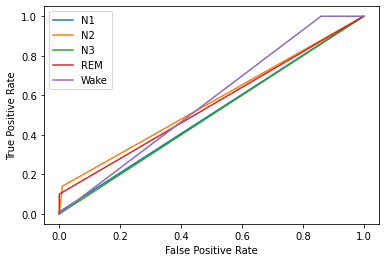

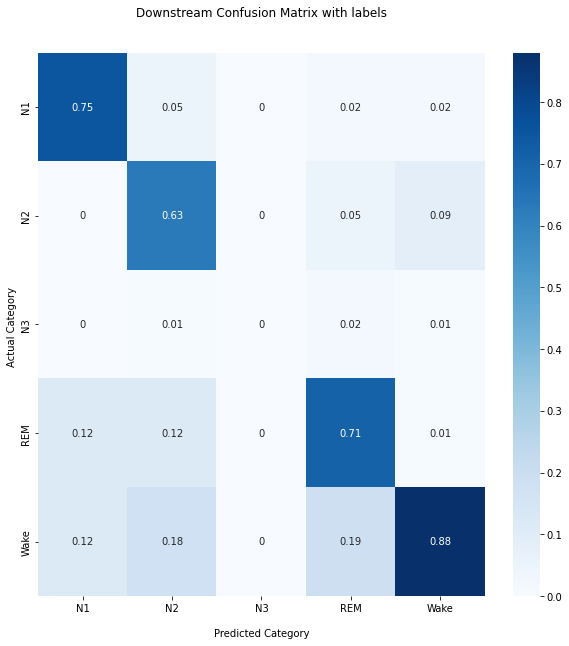

[[ 2290  5711]
 [  269 28943]]
Precision, Recall and F1 Score for Sleep are 0.89, 0.29, 0.44
Precision, Recall and F1 Score for Wake are 0.84, 0.99, 0.91
(2, 2)
Accuracy is 0.84
Performance is 0.73


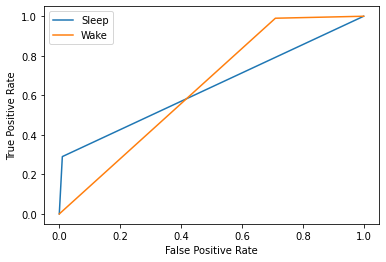

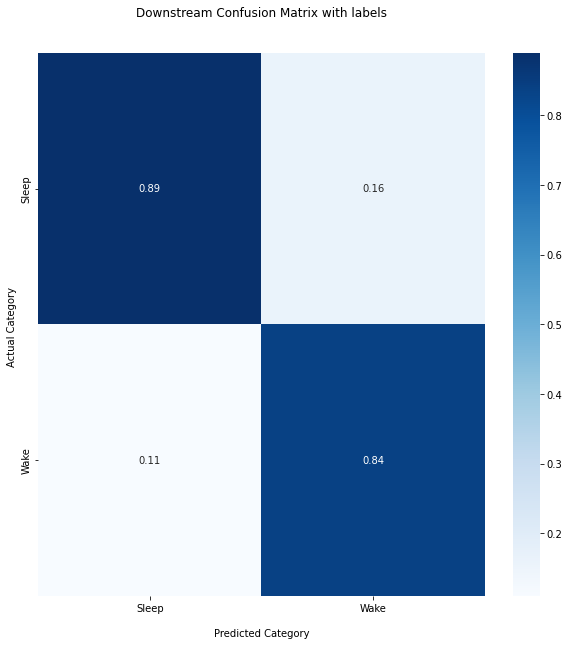

[[11953   747   798     3   541]
 [  872  5834    98     0     1]
 [ 4165   594  5606     0   455]
 [  158    12    97     2   106]
 [ 2380   296    82     0  2413]]
Precision, Recall and F1 Score for Supine are 0.61, 0.85, 0.71
Precision, Recall and F1 Score for Upright are 0.78, 0.86, 0.82
Precision, Recall and F1 Score for Right are 0.84, 0.52, 0.64
Precision, Recall and F1 Score for Prone are 0.4, 0.01, 0.02
Precision, Recall and F1 Score for Left are 0.69, 0.47, 0.56
(5, 5)
Accuracy is 0.69
Performance is 0.59


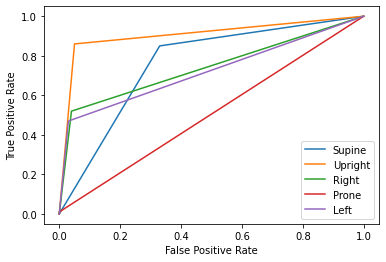

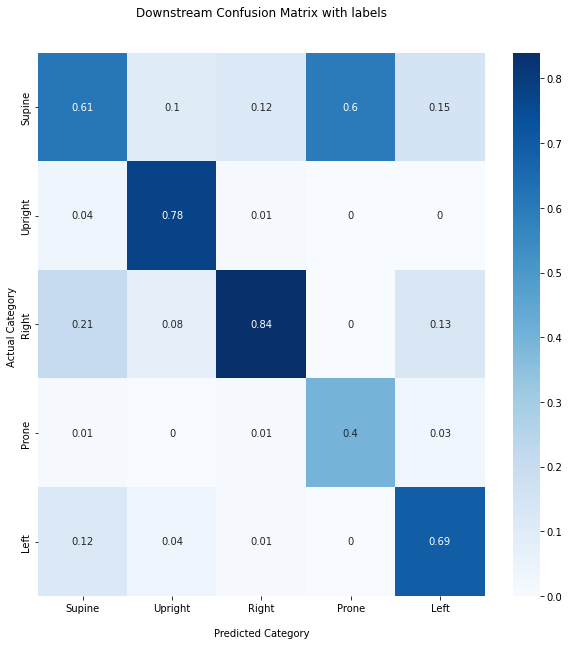

[[ 1244  4003]
 [  408 31558]]
Precision, Recall and F1 Score for Slow are 0.75, 0.24, 0.36
Precision, Recall and F1 Score for Normal are 0.89, 0.99, 0.94
(2, 2)
Accuracy is 0.88
Performance is 0.46


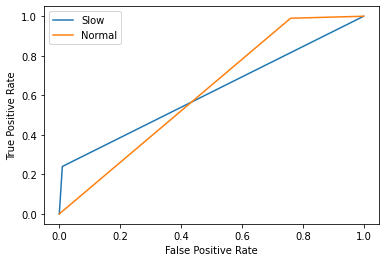

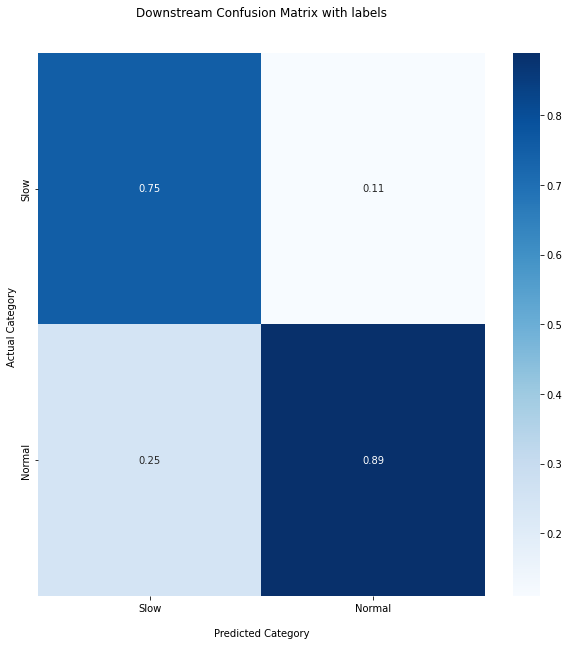

([0.75, 0.89], 0.88)

In [ ]:
test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(y_preds[:][0], axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(y_preds[:][1], axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(y_preds[:][2], axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(y_preds[:][3], axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)


Sleep stage

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=units,
          activation = 'tanh',
          input_shape=[1, x_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))


model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

history = model.fit(x_train, y_train_stage, validation_data=(x_test, y_test_stage), batch_size=128, epochs=3)

test_labels = np.argmax(y_test_stage_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

In [ ]:
Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep wake

Epoch 1/15
23258/23258 [==============================] - 346s 15ms/step - loss: 0.4754 - accuracy: 0.8017 - val_loss: 0.5291 - val_accuracy: 0.7412
Epoch 2/15
23258/23258 [==============================] - 343s 15ms/step - loss: 0.4659 - accuracy: 0.8017 - val_loss: 0.5213 - val_accuracy: 0.7412
Epoch 3/15
23258/23258 [==============================] - 342s 15ms/step - loss: 0.4637 - accuracy: 0.8015 - val_loss: 0.5441 - val_accuracy: 0.7412
Epoch 4/15
23258/23258 [==============================] - 345s 15ms/step - loss: 0.4607 - accuracy: 0.8012 - val_loss: 0.5124 - val_accuracy: 0.7420
Epoch 5/15
23258/23258 [==============================] - 340s 15ms/step - loss: 0.4595 - accuracy: 0.8010 - val_loss: 0.5249 - val_accuracy: 0.7412
Epoch 6/15
23258/23258 [==============================] - 336s 14ms/step - loss: 0.4593 - accuracy: 0.8004 - val_loss: 0.5245 - val_accuracy: 0.7412
Epoch 7/15
23258/23258 [==============================] - 343s 15ms/step - loss: 0.4594 - accuracy: 0.8006

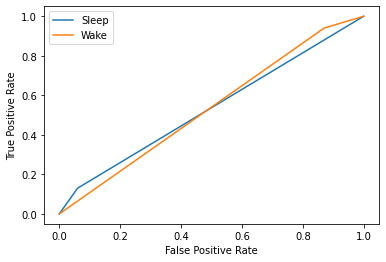

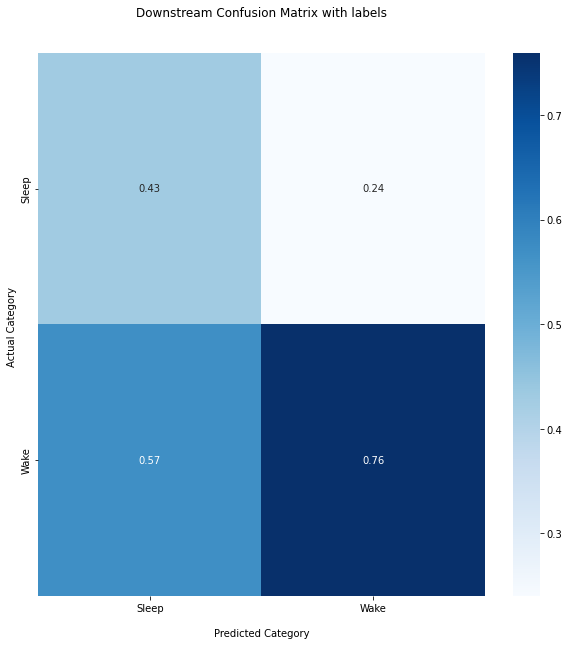

([0.43, 0.76], 0.73)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=units,
          activation = 'tanh',
          input_shape=[49,1]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))


model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)


from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)

history = model.fit(x_train, y_train_wake, validation_data=(x_test, y_test_wake), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_wake_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep pos

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=time_steps,
          activation = 'tanh',
          input_shape=[49,1]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))


model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)

history = model.fit(x_train, y_train_pos, validation_data=(x_test, y_test_pos), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_pos_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep hr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=time_steps,
          activation = 'tanh',
          input_shape=[49,1]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))


model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)

history = model.fit(x_train, y_train_hr, validation_data=(x_test, y_test_hr), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_hr_f, axis=1)
y_pred = np.argmax(model.predict(x_test_f), axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Confusion

In [5]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      if (cf_matrix[i][j] == 0):
        cf_mat[i][j] = 0
      else:
        cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)